In [1]:
import pandas as pd
import pandahouse as ph
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
connection = {'host': '',
'database':'',
'user':'',
'password':''
}
query = '''
SELECT 
     user_id, exp_group,
     sum(action='like') AS likes,
     sum(action='view') AS views,
     likes/views AS ctr
from {db}.feed_actions
where toDate(time) BETWEEN '2025-01-03' AND '2025-01-09' and exp_group in (2, 1)
group by exp_group, user_id
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

## A/B тест

Мы имеем две группы в нашем кейсе - group_1 и group_2, первая является контрольной, а вторая тестовой.
Цель эксперимента - выяснить, есть ли эффект от смены системы рекомендаций новых постов с помощью статистического анализа.

Гипотезы:
    H0 - изменения не привнесли стат значимых изменениий.
    H1 - изменения приведут к увеличению CTR. 

In [8]:
control = df[df.exp_group == 1]
test = df[df.exp_group == 2]

In [9]:
print(f'Кол-во пользователей в Контрольной группе: {control.user_id.count()}')
print(f'Кол-во пользователей в Тестовой группе: {test.user_id.count()}')

Кол-во пользователей в Контрольной группе: 10020
Кол-во пользователей в Тестовой группе: 9877


В группах примерно одинаковое кол-во пользоватей, это хорошо.

Рассмотрим распределение CTR

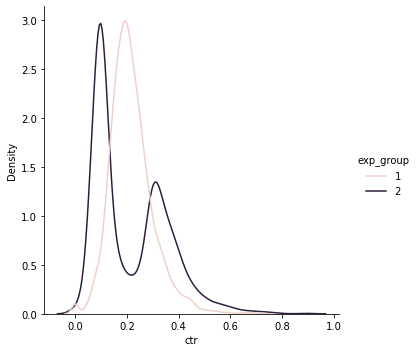

In [10]:
sns.displot(data=df, x='ctr', hue='exp_group', kind="kde")

## T-test

Распределение контрольной группы похоже на нормальное, но тестовая группа не унимодальна. Но так как выбросы не слишком хаотичны и наши CTR пересекаются, и самое главное выборки примерно одинаковы и их много, попробуем воспользоваться тестом Стьюдента беря во внимание увеличение шанса ошибки первого рода.

In [11]:
stats.ttest_ind(control.ctr, test.ctr, equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Т-тест уверенно показал, что стат значимости нет.

## U-критерий

Так как мы работает с большой выборкой и наша метрика - CTR, а не условные единица и ноль, то мы вполне можем воспользоваться U-критерием.

In [13]:
print(stats.mannwhitneyu(control.ctr, test.ctr))

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= control.ctr.sample().values[0] > test.ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)
В 56.49 % случаев A > B. Должно получиться около 50%


Критерий показывает стат значимое отличие.

У нас что-то не сходится. Скорее всего выбросы в тестовой группы повлияли на результат т-теста. В таком случае, выполним сглаживание CTR и проведём т-тест ещё раз.

In [24]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
where toDate(time) BETWEEN '2025-01-03' AND '2025-01-09' and exp_group in (2, 1)
GROUP BY exp_group, user_id
"""

smooth_df = ph.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [30]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [31]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [29]:
stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

Т-тест со сглаженным CTR уже едва показывает отстутствие стат значимого различия.

Что будем делать? Учитывая, что у нас явно виднеется бимодальное распределение у одной из групп, воспринимать результат обычного т-теста как значимый нельзя. Непараметрический критерий как раз хорошо справляется с такими данными, но он не показывается очень уверенной значимости, тем более, что т-тест со сглаженным ctr имеет p-value около 0.05, поэтому мы не можем подтвердить H1. Риск ошибки слишком высок.

## Вывод

Вероятно, сплитование было произведенно неправильно, поэтому a/b тест нужно проводить еще раз, уже с новой сегментацией.